In [1]:
from src.common.h5_util import load_h5_file

import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [1]:
import numpy as np
import einops

In [7]:
x = np.random.rand(4, 8, 12, 400, 300)
x1 = x[:,0::2]

In [15]:
einops.rearrange(x1, 'b c t h w -> (b h w) (c t)').shape

(480000, 48)

# Patch Select

In [ ]:
map_high = load_h5_file('.h5')
plt.imsave('map_high.png', map_high)
dx= 30*10
dy= 30*10
submapx1 = 471*10
submapx2 = 471*10+dx
submapy1 = 138*10
submapy2 = 138*10+dy
plt.imshow(map_high[submapx1:submapx2, submapy1:submapy2])

In [ ]:
map_static = load_h5_file('../data/raw/default/ANTWERP/ANTWERP_static.h5')

In [ ]:
plt.imsave('antwerp.png', map_static[0])

In [ ]:
plt.imshow(map_static[0][217:219,206:207])


In [ ]:
plt.figure(figsize=(30,10))

print (map_static.shape)
plt.imshow(map_static[0])


In [2]:
import pywt
import os
from matplotlib.image import imread
from sklearn.metrics import mean_squared_error

In [ ]:
# input single channel
x = map_static[0].astype(np.float32)
x.shape

In [ ]:
A = imread(os.path.join("/home/shehel/","Downloads","cameraman.png"))
A = np.interp(A, (A.min(), A.max()), (0, 255))
A = x

In [ ]:
n = 1
w = 'db7'
coeffs = pywt.wavedec2(A,wavelet=w, level=n)

# normalizing coefficient array
coeffs[0] /= np.abs(coeffs[0]).max()
for detail_level in range(n):
    coeffs[detail_level+1] = [d/np.abs(d).max() for d in coeffs[detail_level + 1]]
#coeffs[1][-1]=np.zeros((128,128))
#coeffs[-2]=(np.zeros((64,64)),np.zeros((64,64)),np.zeros((64,64)))
#coeffs[-1]=(np.zeros((128,128)),np.zeros((128,128)),np.zeros((128,128)))
#coeffs[-2]=(np.zeros((128,128)),np.zeros((128,128)),np.zeros((128,128)))
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
plt.imshow(arr, vmin=-0.25, vmax=0.75)
plt.rcParams['figure.figsize'] = [16,16]
fig = plt.figure(figsize=(18,16))
plt.show()



In [ ]:

coeffs = pywt.wavedec2(A,wavelet='db1', level=2)
#coeffs[-1]=(coeffs[-1][0],coeffs[-1][1],np.zeros((128,128)))
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeffs_filt = pywt.array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedec2')

recon = pywt.waverec2(coeffs_filt, wavelet=w)
#plt.figure()
plt.imshow(recon,cmap='gray')
plt.axis('off')
plt.rcParams['figure.figsize'] = [16,16]


In [ ]:
plt.imshow(x)

In [ ]:
w = 'db1'
coeffs = pywt.wavedec2(A,wavelet=w, level=1)
dim1, dim2 = coeffs[-1][0].shape 

#coeffs[-2]=(np.zeros((64,64)),np.zeros((64,64)),np.zeros((64,64)))
#coeffs[-1]=(np.zeros((256,256)),np.zeros((256,256)),np.zeros((128,128)))
coeffs[-1]=(np.zeros((dim1,dim2)),np.zeros((dim1,dim2)),np.zeros((dim1,dim2)))
#coeffs[-1]=(coeffs[-1][0],coeffs[-1][1],np.zeros((dim1,dim2)))
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeffs_filt = pywt.array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedec2')

recon = pywt.waverec2(coeffs_filt, wavelet=w)
plt.figure()
plt.imshow(recon)
#plt.axis('off')
#pt.rcParams['figure.figsize'] = [16,16]


In [ ]:
mean_squared_error(recon[:495], A)

In [ ]:
max(A.flatten())

In [ ]:
plt.imshow(A - recon[:495], cmap='gray')
max((A - recon[:495]).flatten())

In [ ]:
plt.imshow(coeff_arr, vmin=-0.25, vmax=0.75)
plt.rcParams['figure.figsize'] = [16,16]
fig = plt.figure(figsize=(18,16))
plt.show()


In [ ]:
## Wavelet Compression
n = 4
w = 'db1'
coeffs = pywt.wavedec2(A,wavelet=w,level=n)

coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

for keep in (0.8,0.5):
    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind # Threshold small indices
    
    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec2')
    
    # Plot reconstruction
    Arecon = pywt.waverec2(coeffs_filt,wavelet=w)
    plt.figure()
    plt.imshow(Arecon,cmap='gray')
    plt.axis('off')
    plt.title('keep = ' + str(keep))

In [ ]:
mean_squared_error(Arecon[:495], A)

In [ ]:
mean_squared_error(recon.round()[:495, :], x)

In [ ]:
recon.round()

In [ ]:
import numpy as np
import pywt
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

x = map_static[0].astype(np.float32)
shape = x.shape

max_lev = 3       # how many levels of decomposition to draw
label_levels = 3  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(2, 4, figsize=[28, 16])
for level in range(0, max_lev + 1):
    if level == 0:
        # show the original image before decomposition
        axes[0, 0].set_axis_off()
        axes[1, 0].imshow(x, cmap=plt.cm.gray)
        axes[1, 0].set_title('Image')
        axes[1, 0].set_axis_off()
        continue

    # plot subband boundaries of a standard DWT basis
    draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                     label_levels=label_levels)
    axes[0, level].set_title('{} level\ndecomposition'.format(level))

    # compute the 2D DWT
    c = pywt.wavedec2(x, 'db2', mode='periodization', level=level)
    # normalize each coefficient array independently for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c)
    axes[1, level].imshow(arr, cmap=plt.cm.gray)
    axes[1, level].set_title('Coefficients\n({} level)'.format(level))
    axes[1, level].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(30,10))

print (map_static.shape)
plt.imshow(map_static[0, ::4, ::4])
print (map_static[0, ::4, ::4].shape)

In [ ]:
plt.figure(figsize=(30,10))

print (map_static.shape)
plt.imshow(map_static[0])

In [ ]:
plt.imsave('map_low.png',map_static[0])

In [ ]:
dx= 24
dy= 30
submapx1 = 461
submapx2 = 461+dx
submapy1 = 138
submapy2 = 138+dy

In [ ]:
map_static[0].shape

In [ ]:
# X and y axes reversed in gimp, 
#in google maps, had to rotate 90 clockwise to align 
plt.imshow(map_static[0][submapx1:submapx2, submapy1:submapy2])

In [4]:
training_files = sorted(glob.glob("../../NeurIPS2021-traffic4cast/data/raw/MOSCOW/training/2019*.h5", recursive=True))
print(f"Found {len(training_files)} training files")
num_files = len(training_files)


Found 180 training files


In [5]:
dataset_raw = np.zeros(shape=(num_files,288, 4, 8))
for idx,file in tqdm((enumerate(training_files[:]))):
    dataset_raw[idx,:,0] = load_h5_file(file)[:,119, 63,:]
    dataset_raw[idx,:,1] = load_h5_file(file)[:,108, 69,:]
    dataset_raw[idx,:,2] = load_h5_file(file)[:,47, 100,:]
    dataset_raw[idx,:,3] = load_h5_file(file)[:,17, 117,:]


0it [00:00, ?it/s]

In [7]:
dataset_raw.shape

(180, 288, 4, 8)

In [15]:
mean = np.mean(dataset_raw, 0)

In [16]:
dataset_detrend = dataset_raw - mean

In [61]:
%matplotlib
plt.figure(figsize=(10,5))
plt.plot(mean[:,2,4])

Using matplotlib backend: TkAgg


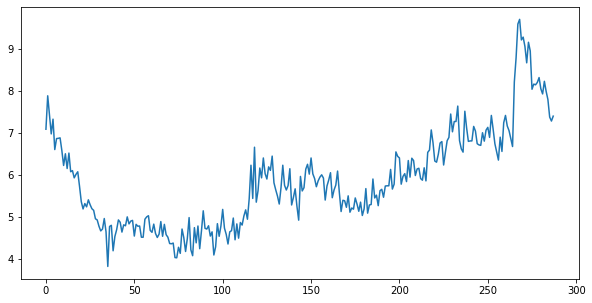

In [17]:
plt.figure(figsize=(10,5))
plt.plot(mean[:,2,4])

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

In [57]:
thres = []
for i in dataset_detrend[2,:,2,5].flatten():
    if i<-30 or i>30:
        thres.append(i)
    else:
        thres.append(0)

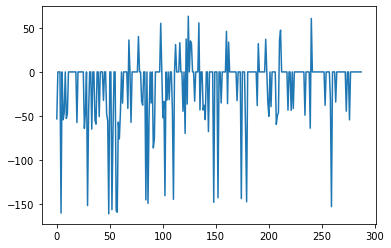

In [58]:
plt.plot(thres)

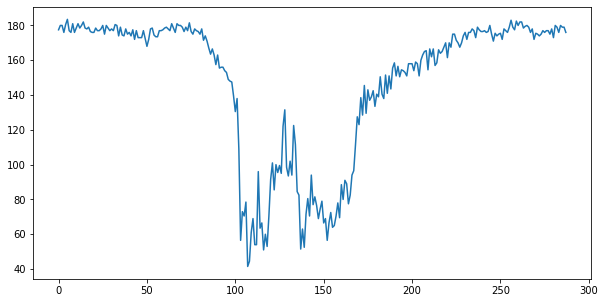

In [84]:
plt.figure(figsize=(10,5))
plt.plot(mean[:,3,3])

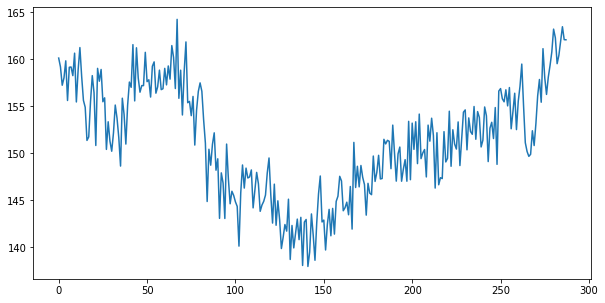

In [64]:
plt.figure(figsize=(10,5))
plt.plot(mean[:,2,5])

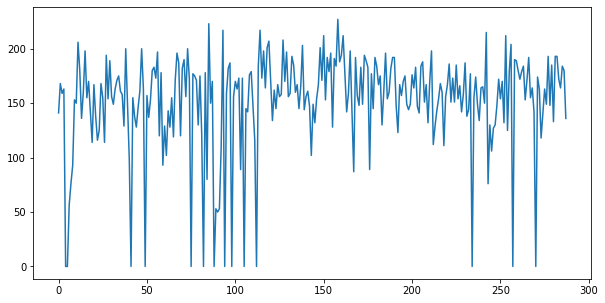

In [83]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.plot(dataset_raw[2,:,3,3].flatten())

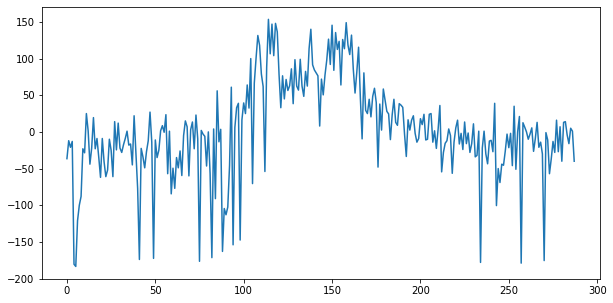

In [85]:
plt.figure(figsize=(10,5))
plt.plot(dataset_detrend[2,:,3,3].flatten())

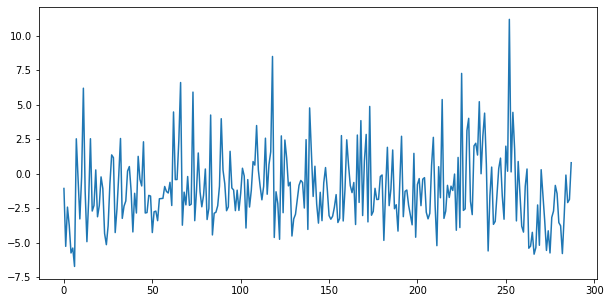

In [35]:
plt.figure(figsize=(10,5))
plt.plot(dataset_detrend[2,:,3,4].flatten())

In [9]:
dataset_detrend.shape

(180, 288, 4, 8)

In [10]:
dataset_detrend.shape

(180, 288, 4, 8)

In [25]:
8.05558500e-02

0.08055585

In [34]:
sm.tsa.stattools.ccf(dataset_raw[2,:,0,4].flatten(), dataset_raw[0,:,2,4].flatten(), adjusted=False)

array([ 1.30872146e-01,  1.59008905e-01, -2.71705775e-04,  1.03073702e-01,
        4.00983750e-02,  6.10414930e-02,  8.11028858e-02,  1.63758849e-02,
        3.15620297e-02,  1.19182113e-01,  3.08531414e-02,  8.75524939e-02,
        5.57010332e-02,  5.52045415e-02,  2.19384933e-02,  6.06309290e-02,
        4.38100109e-02,  3.25708984e-02,  5.90295822e-02,  1.42912270e-01,
        7.59448920e-02,  1.20721084e-01,  1.48770994e-01,  7.06341175e-02,
        3.94215026e-02,  1.44936631e-01,  1.19532509e-01,  7.10254229e-02,
        1.56846728e-01,  3.13940383e-02,  7.81971673e-02,  9.26311226e-02,
        7.25615112e-02,  9.38063881e-02,  7.94746138e-02,  1.38399623e-01,
        7.40362050e-02,  7.29597472e-02,  1.45538984e-01,  5.40893825e-02,
        3.07710777e-02,  1.05107876e-01,  1.14956567e-01,  6.83262744e-02,
        7.87299069e-02,  8.15689563e-02,  7.74160285e-02,  7.66545777e-02,
        1.29710742e-01,  1.31223524e-01,  3.98622425e-02, -4.09637855e-03,
        6.58627065e-02,  

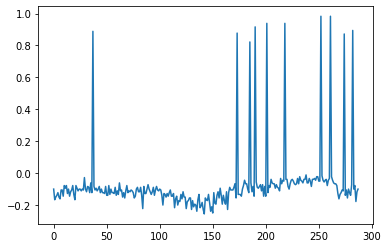

In [24]:
plt.plot(dataset_detrend[0, :, 1, 0])

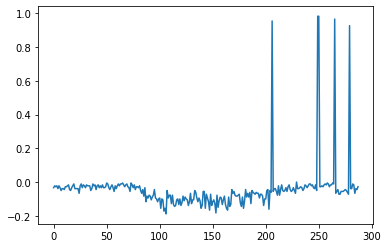

In [21]:
plt.plot(dataset_detrend[0, :, 0, 0])

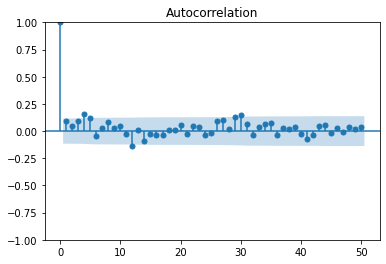

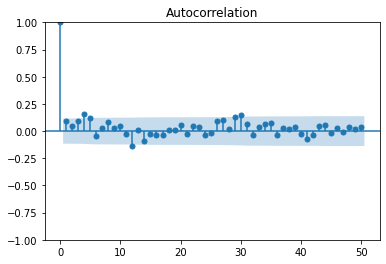

In [59]:
%matplotlib inline
plot_acf(thres, lags = 50)

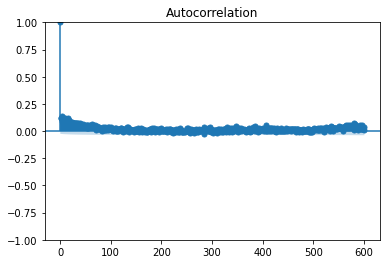

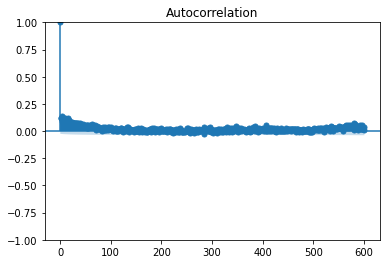

In [31]:
%matplotlib inline
plot_acf(dataset_detrend[:20,:,0,5].flatten(), lags = 600)

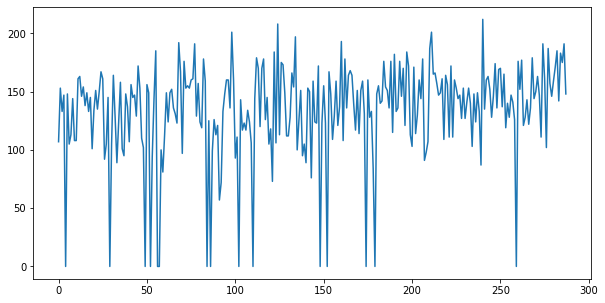

In [18]:
plt.figure(figsize=(10,5))
plt.plot(dataset_raw[2,:,2,5].flatten())

In [3]:
def running_mean(x, N):
  #""" x == an array of data. N == number of samples per average """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [ ]:
load_h5_file(file).shape

In [ ]:
%matplotlib 
fig, ax1 = plt.subplots(1, 1)
ax1.xcorr(running_mean(dataset_raw[0,:,0,2],6), running_mean(dataset_raw[0,:,1,2],6), usevlines=True, maxlags=200, normed=True, lw=2)
ax1.grid(True)

In [ ]:
np.corrcoef(running_mean(dataset_raw[0,:,1,2],6),running_mean(dataset_raw[0,:,0,4],6))

In [ ]:
plt.plot(running_mean(dataset_raw[0,:,1,0],3))
plt.plot(running_mean(dataset_raw[0,:,1,2],3))
plt.plot(running_mean(dataset_raw[0,:,1,4],3))
plt.plot(running_mean(dataset_raw[0,:,1,6],3))


In [ ]:
%matplotlib inline
for i in range(0,8,2):
    plt.plot(running_mean(dataset_raw[0,:,1,i],3))

plt.plot(running_mean(dataset_raw[0,:,0,4],3))

In [ ]:
#30, 109 is very close to 5 min mark

In [ ]:
num_files=len(training_files)

In [ ]:
dataset_raw = np.zeros(shape=(num_files,288, 495,436, 8))
for idx,file in tqdm((enumerate(training_files[:num_files]))):
    dataset_raw[idx] = load_h5_file(file)[:,:, :,:]
    dataset_raw[idx] = load_h5_file(file)[:,:, :,:]

In [ ]:
means.shape

In [ ]:
means = np.mean(dataset_raw, axis=0)
dataset_detrend = dataset_raw-np.reshape(means, (1, 288, 4, 8))

In [ ]:
dataset_raw.shape

In [ ]:
plt.plot(dataset_raw[:,:,0,4].flatten())

In [ ]:
dataset_raw = np.zeros(shape=(num_files,288, 4, 8))
for idx,file in tqdm((enumerate(training_files[:num_files]))):
    loaded_file = load_h5_file(file)
    dataset_raw[idx,:,0] = loaded_file[:,123, 61,:]
    dataset_raw[idx,:,2] = loaded_file[:,47, 100,:]
    dataset_raw[idx,:,1] = loaded_file[:,86, 80,:]
    dataset_raw[idx,:,3] = loaded_file[:,14, 125,:]

#for i in range(0,8,2):
#    plt.plot(running_mean(dataset_raw[0,:,0,i], 6))

#plt.plot(running_mean(dataset_raw[0,:,0,4],3))
#plt.plot(running_mean(dataset_raw[0,:,1,4],3))

In [4]:
points = [(123,61), (86,80), (47,100), (30, 109),(14,125), (388,307)]

In [ ]:
dataset_raw.shape

In [ ]:
%matplotlib inline
plt.plot(dataset_detrend[0,:,x,4])

In [ ]:
%matplotlib inline
fig, ax1 = plt.subplots(1, 1)
x = 0
x1 = 1
ax1.xcorr(running_mean(dataset_detrend[0,:,x,4],3), running_mean(dataset_detrend[0,:,x1,4],3), usevlines=True, maxlags=200, normed=True, lw=2, label=str(x1))
ax1.legend()
ax1.grid(True)

In [ ]:
%matplotlib 
fig, ax1 = plt.subplots(1, 1)
x,y = points[0]
x2,y2 = points[-2]
ax1.xcorr(running_mean(dataset_raw[0,:,x,y,4],3), running_mean(dataset_raw[0,:,x2,y2,4],3), usevlines=True, maxlags=200, normed=True, lw=2)
ax1.grid(True)

In [ ]:
plt.plot(running_mean(dataset_raw[0,:,x2,y2,4],3))
plt.plot(running_mean(dataset_raw[0,:,x,y,4],3))

In [ ]:
for x,y in points:
    plt.plot(running_mean(dataset_raw[0,:,x,y,4], 24))

In [ ]:
for i in range(0,8,2):
    plt.plot(running_mean(dataset_raw[0,:,1,i], 3))

In [ ]:
dataset_raw.shape

In [ ]:
dataset_raw = np.zeros(shape=(num_files,288, dx, dy, 8))
for idx,file in tqdm((enumerate(training_files[:num_files]))):
    dataset_raw[idx] = load_h5_file(file)[:,submapx1:submapx2, submapy1:submapy2,:]
    

In [ ]:
import h5py
hf = h5py.File('dataset_raw.h5', 'r')
#hf.create_dataset('ds1', data=dataset_raw)

n1 = hf.get('ds1')
dataset_raw = np.array(n1)

In [ ]:
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

In [ ]:
plt.plot(dataset_raw[0, :,0,2])

In [ ]:
plt.plot(dataset_detrend[0,:,0,4])
plt.plot(dataset_raw[0, :, 0,4])
plt.plot(dataset1[:288,x,4])

In [ ]:
%matplotlib 
fig, ax1 = plt.subplots(1, 1)
x = 0
x1 = 3
ax1.xcorr(running_mean(dataset_detrend[0,:,x,4],3), running_mean(dataset_detrend[0,:,x1,4],3), usevlines=True, maxlags=200, normed=True, lw=2, label=str(x1))
ax1.legend()
ax1.grid(True)

In [ ]:
fig, ax1 = plt.subplots(1, 1)
x = 0
x1 = 1
ax1.xcorr(running_mean(dataset1[:288,x,2],3), running_mean(dataset1[:288,x1,2],3), usevlines=True, maxlags=200, normed=True, lw=2, label=str(x1))
ax1.legend()
ax1.grid(True)

In [ ]:
dataset_raw.shape

In [ ]:
means.shape

In [ ]:
# Dataset with user-defined points
dataset1 = dataset_raw-np.mean(dataset_raw, axis=0)
dataset1 = np.reshape(dataset1, (num_files*288, 4,8))


#means = np.mean(dataset_raw, axis=0)
#dataset_detrend = dataset_raw-np.reshape(means, (1, 288, 4, 8))

In [ ]:
dataset1 = np.reshape(dataset_raw, (num_files*288, dx, dy,8))

In [ ]:
dataset1 = dataset_raw-np.mean(dataset_raw, axis=0)
dataset1 = np.reshape(dataset1, (num_files*288, dx, dy,8))

In [ ]:
dataset1.shape

In [ ]:
plt.figure(figsize=(30,10))

days = 10
pixels = [[0,5],[0,15],[9,14],[13,13],[23,10],[23,11]]
pixels = [[0,5],[9,14],[23,11]]

for x,y in pixels:
        #print (map_static[submapx1:submapx2, submapy1:submapy2])
        #print (map_static[submapx1:submapx2, submapy1:submapy2][x,y])
    plt.plot(moving_avg(dataset1[:1000,x,y,0], 2), label=str(x)+str(y))
    plt.plot(moving_avg(dataset1[:1000,x,y,2], 2), label=str(x)+str(y), linestyle='dashed')
    plt.legend()

## Cross correlation

In [ ]:
plt.plot(moving_avg(dataset1[:1000,9,14,2], 6))
plt.plot(moving_avg(dataset1[:1000,23,10,2], 6))

In [ ]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
ax1.xcorr(moving_avg(dataset1[:1000,9,14,2], 6),moving_avg(dataset1[:1000,23,10,2], 6), usevlines=False, maxlags=990, normed=True, lw=1)
ax1.grid(True)

In [ ]:
np.corrcoef(moving_avg(dataset1[:1000,9,14,2], 6),moving_avg(dataset1[:1000,23,10,2], 6))

## Make DS

In [ ]:
Xs[-3:]

In [ ]:
ys[-3:]

In [ ]:
# user defined points
history = 3
step_ahead = 0
target_channel = 4 # South 
pixels = [3,0]
target_pixel = 3
Xs = []
ys = []
for i in range(len(dataset1)-(history+step_ahead)):
    sample_x = []
    for x in pixels:
        sample_x.extend(list(dataset1[i:i+history,x,target_channel]))
      
    Xs.append(sample_x)
    ys.append(dataset1[i+history+step_ahead, target_pixel, target_channel])

In [ ]:
history = 3
step_ahead = 1
target_channel = 2 # South 
pixels = [[13,13]]
target_pixel = [13,13]
Xs = []
ys = []
for i in range(len(dataset1)-(history+step_ahead)):
    sample_x = []
    for x,y in pixels:
        sample_x.extend(list(dataset1[i:i+history,x,y,target_channel]))
      
    Xs.append(sample_x)
    ys.append(dataset1[i+history+step_ahead,target_pixel[0], target_pixel[1], target_channel])

In [ ]:
history = 6
step_ahead = 1
target_channel = 2 # South 
pixels = [[13,13]]
target_pixel = [13,13]
Xs = []
ys = []
for i in range(len(dataset1)-(history+step_ahead)):
    sample_x = []
    for x,y in pixels:
        sample_x.extend(list(dataset1[i:i+history,x,y,target_channel]))
      
    Xs.append(sample_x)
    ys.append(dataset1[i+history+step_ahead,target_pixel[0], target_pixel[1], target_channel])

In [ ]:
dataset1[:14,target_pixel[0],target_pixel[1],target_channel]

In [ ]:
plt.figure(figsize=(30,10))


for x in Xs[:1]:
    for tr, y in zip(ys,range(0,36,6)):
        
        #print (map_static[submapx1:submapx2, submapy1:submapy2])
        #print (map_static[submapx1:submapx2, submapy1:submapy2][x,y])
        plt.plot(x[y:y+6])
        

# Baseline

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
reg1 = LinearRegression().fit(train_x.cpu(), train_y.cpu())
#reg2 = MLPRegressor(random_state=1, max_iter=1000).fit(train_x.cpu(), train_y.cpu())


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessRegressor(kernel=kernel,
         random_state=0).fit(train_x.cpu(), train_y.cpu())

In [ ]:
predsg = gpc.predict(test_x.cpu())

plt.plot(test_y.cpu())
plt.plot(predsg, label='gpr')

In [ ]:
preds1 = reg1.predict(test_x.cpu())
#preds2 = reg2.predict(test_x.cpu())

In [ ]:
plt.plot(test_y.cpu()[:288])
plt.plot(preds1[:288], label='LR')
#plt.plot(preds1[:288], label='LR')

plt.legend()

In [ ]:
print('Test MAE: {}'.format(torch.mean(torch.abs(torch.tensor(preds1) - test_y.cpu()))))

# GP
Ref https://docs.gpytorch.ai/en/v1.1.1/examples/02_Scalable_Exact_GPs/Simple_GP_Regression_CUDA.html#Introduction

In [ ]:
import math
import torch
import gpytorch

%load_ext autoreload
%autoreload 2

In [ ]:
train_x = torch.tensor(Xs[:-1000], dtype=torch.float32)
train_y = torch.tensor(ys[:-1000], dtype=torch.float32)

In [ ]:
test_x = torch.tensor(Xs[-1000:], dtype=torch.float32)
#test_x = test_x.cuda()
test_y = torch.tensor(ys[-1000:], dtype=torch.float32)
#test_y = test_y.cuda()

In [ ]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3, ard_num_dims=6).cuda()
        #self.covar_module.initialize_from_data(train_x, train_y)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [ ]:
train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()


In [ ]:
# this is for running the notebook in our testing framework
import os
training_iter = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()



In [ ]:
model.eval()
likelihood.eval()
#means = torch.tensor([0.])

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_pred = likelihood(model(test_x))
    means = observed_pred.mean.cpu().numpy()
        #means = torch.cat([means, preds.mean.cpu()])
#means = means[1:]

In [ ]:
plt.plot(test_y.cpu())
plt.plot(means)

# Approximate GP

In [ ]:
if torch.cuda.is_available():
    train_x, train_y = train_x.cuda(), train_y.cuda()


from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x[:40000], train_y[:40000])
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(train_x[40000:], train_y[40000:])
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class SpectralMixtureGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(SpectralMixtureGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        #self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=6).cuda()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = train_x[:5000, :]
model = SpectralMixtureGPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [ ]:
num_epochs =  1


model.train()
likelihood.train()

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))


epochs_iter = tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()



In [ ]:
model.eval()
likelihood.eval()
means = torch.tensor([0.])
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        print ("hello")
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])
        print (means)
means = means[1:]

In [ ]:
print('Test MAE: {}'.format(torch.mean(torch.abs(means - train_y[40000:].cpu()))))

In [ ]:
import urllib.request
import os
from scipy.io import loadmat
from math import floor


# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)


if not smoke_test and not os.path.isfile('../elevators.mat'):
    print('Downloading \'elevators\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1jhWL3YUHvXIaftia4qeAyDwVxo6j1alk', '../elevators.mat')


if smoke_test:  # this is for running the notebook in our testing framework
    X, y = torch.randn(1000, 3), torch.randn(1000)
else:
    data = torch.Tensor(loadmat('../elevators.mat')['data'])
    X = data[:, :-1]
    X = X - X.min(0)[0]
    X = 2 * (X / X.max(0)[0]) - 1
    y = data[:, -1]


train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [ ]:
#plt.plot(train_y[40000:].cpu())
plt.plot(means[:288])

In [ ]:
plt.figure(figsize=(30,10))

days = 10
for x in range(2,3):
    for y in [0,7, 15,25, 29]:
        x
        #print (map_static[submapx1:submapx2, submapy1:submapy2])
        #print (map_static[submapx1:submapx2, submapy1:submapy2][x,y])
        plt.plot(moving_avg(dataset1[:288*days,x,y,6], 12), label=str(x)+str(y))
        plt.legend()

In [ ]:
mean = np.mean(dataset_raw, axis=0)

In [ ]:
plt.figure(figsize=(30,10))

plt.plot(moving_avg(dataset1[:288*3,x,0,6], 6), label=str(x)+str(y))
plt.plot(moving_avg(dataset1[:288*3,x,29,6]*6, 6), label=str(x)+str(y))


In [ ]:
from scipy.fft import rfft, rfftfreq

SAMPLE_RATE=288
DURATION = 3
# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

yf = rfft(dataset1[:288*3,2,29,6])
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.figure(figsize=(25,25))

plt.plot(xf, np.abs(yf))
plt.show()


In [ ]:
from scipy.fft import rfft, rfftfreq

SAMPLE_RATE=288
DURATION = num_files
# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

yf = rfft(dataset1[:288*num_files,2,0,6])
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.figure(figsize=(25,25))

plt.plot(xf, np.abs(yf))
plt.show()


In [ ]:
import mogptk

In [ ]:
start_date = '2020-01-02'
end_date = '2020-01-05'

In [ ]:
dataset = np.reshape(dataset1, (num_files*288, 4, 14,8))


In [ ]:
dataset=dataset1

In [ ]:
dataset = dataset[:288*3]

In [ ]:
import pandas as pd

In [ ]:
first = pd.DataFrame(dataset[:,2,0,:])
second = pd.DataFrame(dataset[:,2,7,:])
third = pd.DataFrame(dataset[:,2,15,:])
fourth = pd.DataFrame(dataset[:,2,25,:])
fifth = pd.DataFrame(dataset[:,2,29,:])

In [ ]:
#bramblemet = pd.read_csv('data/bramblemet/bramblemet.csv.gz', compression='gzip', low_memory=False)
first['Date'] = pd.date_range(start=start_date, end=end_date, freq='5t')[:-1]
second['Date'] = pd.date_range(start=start_date, end=end_date, freq='5t')[:-1]
third['Date'] = pd.date_range(start=start_date, end=end_date, freq='5t')[:-1]
fourth['Date'] = pd.date_range(start=start_date, end=end_date, freq='5t')[:-1]
fifth['Date'] = pd.date_range(start=start_date, end=end_date, freq='5t')[:-1]

In [ ]:
ds_mogptk = mogptk.DataSet(
    mogptk.LoadDataFrame(first, x_col='Date', y_col=6, name='1'),
    mogptk.LoadDataFrame(second, x_col='Date', y_col=6, name='2'),
        mogptk.LoadDataFrame(third, x_col='Date', y_col=6, name='3'),
        mogptk.LoadDataFrame(fourth, x_col='Date', y_col=6, name='4'),
        mogptk.LoadDataFrame(fifth, x_col='Date', y_col=6, name='5'),

)

In [ ]:
for i, data in enumerate(ds_mogptk):
    #data.transform(mogptk.TransformDetrend)
    data.remove_randomly(pct=0.6)

In [ ]:
ds_mogptk['1'].remove_range(start='2020-01-04 12:00:00', end='2020-01-05')
ds_mogptk['2'].remove_range(start='2020-01-04 12:00:00', end='2020-01-05')
ds_mogptk['3'].remove_range(start='2020-01-04 12:00:00', end='2020-01-05')
ds_mogptk['4'].remove_range(start='2020-01-04 12:00:00', end='2020-01-05')
ds_mogptk['5'].remove_range(start='2020-01-04 12:00:00', end='2020-01-05')

In [ ]:
ds_mogptk.plot(transformed=True);

In [ ]:
ds_mogptk.plot_spectrum(per='day', maxfreq=10, transformed=True);

In [ ]:
method = 'Adam'
lr = 0.1
iters = 500

In [ ]:
mosm = mogptk.MOSM(ds_mogptk, Q=10)
mosm.init_parameters(method='LS')
mosm.train(method=method, lr=lr, iters=iters, verbose=True)
mosm.predict();
mosm.print_parameters()

In [ ]:
ds_mogptk.plot(figsize=(25,25));

In [ ]:
ds_mogptk.plot(figsize=(25,25));

In [ ]:
ds_mogptk.plot(figsize=(25,25));

In [ ]:
ds_mogptk.plot(figsize=(25,25));

In [ ]:
ds_mogptk.plot(figsize=(25,25));

In [ ]:
import torch

In [ ]:
torch.cuda.is_available()